In [405]:
# Libraries générales
import numpy as np
import pandas as pd
import os
import random
import time
import datetime
from time import time
import shutil

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# TensorFlow, Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import vgg16, VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.applications.vgg16 import preprocess_input
from keras.utils import to_categorical
from keras import Input
from kerastuner import RandomSearch, HyperParameters
from keras.regularizers import l2
from keras.layers import Dropout

# PIL Traitement d'image
from PIL import Image
from PIL import ImageOps

# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder




In [303]:
data = pd.read_pickle('data/cleaned/df_clean1.pkl')
path_to_images = "./data/source/Flipkart/images/"

In [304]:
data.head()

,uniq_id,image,product_name,brand,description,main_category,sub_category1,sub_category2,combined
0,55b85ea15a1536d46b7190ad6fff8ce7,55b85ea15a1536d46b7190ad6fff8ce7.jpg,elegance polyester multicolor abstract eyelet ...,elegance,key elegance polyester multicolor abstract eye...,Home Furnishing,Curtains & Accessories,Curtains,elegance polyester abstract eyelet door curtai...
1,7b72c92c2f6c40268628ec5f14c6d590,7b72c92c2f6c40268628ec5f14c6d590.jpg,cotton bath towel,,cotton bath towel bath towel red yellow blue b...,Baby Care,Baby Bath & Skin,Baby Bath Towels,cotton bath towel cotton bath towel bath towel...
2,64d5d4a258243731dc7bbb1eef49ad74,64d5d4a258243731dc7bbb1eef49ad74.jpg,cotton terry face towel,,key cotton terry face towel size small height ...,Baby Care,Baby Bath & Skin,Baby Bath Towels,cotton terry face towel cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,d4684dcdc759dd9cdf41504698d737d8.jpg,royal fashion cotton printed king sized double,royal fashion,key royal fashion cotton printed king sized do...,Home Furnishing,Bed Linen,Bedsheets,royal fashion cotton printed king sized double...
4,6325b6870c54cd47be6ebfbffa620ec7,6325b6870c54cd47be6ebfbffa620ec7.jpg,cotton floral king sized double,,key cotton floral king sized double cotton flo...,Home Furnishing,Bed Linen,Bedsheets,cotton floral king sized double cotton floral ...


# Transfert Learning

## Convolutional Neural Networks, CNN (VGG16)

In [ ]:
'''
VGG16 est une architecture de réseau neuronal convolutionnel profond (CNN) conçue et 
formée par le Visual Geometry Group (VGG) d'Oxford.
Le nombre « 16 » représente le nombre de couches avec poids dans le réseau.
'''

In [305]:
# Chargement du modèle VGG16 pré-entraîné sans couches supérieures
#Nous utiliserons le modèle CNN pré-entraîné

image_paths = [os.path.join(path_to_images, img_name) for img_name in data['image']]
base_model = VGG16(weights='imagenet', include_top=False)

def extract_features_from_image(img_path):
    """Une fonction pour extraire des caractéristiques d'une image en utilisantVGG16"""
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = base_model.predict(img_array)
    return features.flatten()

# Extraction de fonctionnalités pour notre ensemble d'images
features_list = [extract_features_from_image(img_path) for img_path in image_paths]

1/1 [==============================] - 0s 113ms/step


1/1 [==============================] - 0s 116ms/step


1/1 [==============================] - 0s 112ms/step


1/1 [==============================] - 0s 126ms/step


1/1 [==============================] - 0s 110ms/step


/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3157: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


1/1 [==============================] - 0s 115ms/step


1/1 [==============================] - 0s 127ms/step


1/1 [==============================] - 0s 99ms/step


In [306]:
labels = data['main_category'].tolist()

In [307]:
%%time
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(features_list, labels, test_size=0.3, random_state=42)

svm_cnn = SVC(kernel='linear', C=1)

svm_cnn.fit(X_train_cnn, y_train_cnn)

y_pred_cnn = svm_cnn.predict(X_test_cnn)

accuracy_cnn = accuracy_score(y_test_cnn, y_pred_cnn)
print("Accuracy CVM:", accuracy_cnn)

Accuracy CVM: 0.8380952380952381
CPU times: user 54.8 s, sys: 515 ms, total: 55.3 s
Wall time: 9.49 s


Le modèle classe correctement environ 83,8 % des échantillons dans l'ensemble de test. 
Le temps réel (le temps de l'horloge murale) qui s'est écoulé lors de l'exécution de la cellule. Cela fait  9.21 secondes.
On peut conclure que l'utilisation des fonctionnalités obtenues à partir de VGG16 pour la classification d'images à l'aide de SVM a donné une précision assez élevée sur l'ensemble de test

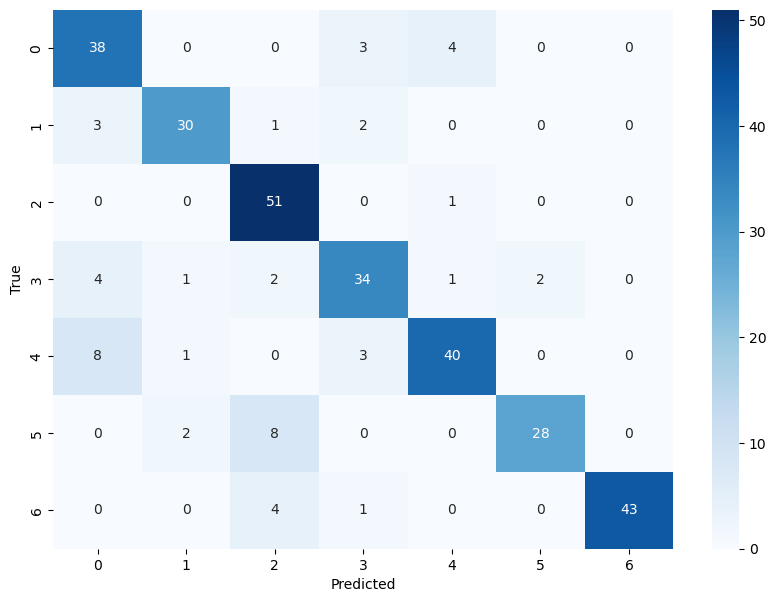

In [309]:
#Confusion Matrix

cm = confusion_matrix(y_test_cnn, y_pred_cnn)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [310]:
# Classification Report
report = classification_report(y_test_cnn, y_pred_cnn)
print(report)

                            precision    recall  f1-score   support

                 Baby Care       0.72      0.84      0.78        45
  Beauty and Personal Care       0.88      0.83      0.86        36
                 Computers       0.77      0.98      0.86        52
Home Decor & Festive Needs       0.79      0.77      0.78        44
           Home Furnishing       0.87      0.77      0.82        52
          Kitchen & Dining       0.93      0.74      0.82        38
                   Watches       1.00      0.90      0.95        48

                  accuracy                           0.84       315
                 macro avg       0.85      0.83      0.84       315
              weighted avg       0.85      0.84      0.84       315



# Deep Neural Network (Fully Connected Neural Network / Dense Neural Network)

In [ ]:
'''
Ce modèle est un réseau de neurones traditionnel. 
Les données d'entrée d'un tel réseau sont simplement des vecteurs de caractéristiques (extraits d'images).
Le modèle comporte plusieurs couches « denses » (dense) dans lesquelles chaque neurone est connecté à tous les neurones de la couche précédente.
'''

In [311]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(data['main_category'])

In [312]:
# Nous encodons les étiquettes en catégories
y_categorical = to_categorical(y_encoded)

X_array = np.array(features_list)

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X_array, y_categorical, test_size=0.3, random_state=42)


In [219]:
#La fonction qui crée le modèle et définit les hyperparamètres

def build_model(hp):
    model = keras.models.Sequential()

    model.add(keras.layers.Dense(units=hp.Int('units_input',
                                        min_value=128,
                                        max_value=512,
                                        step=32),
                           activation='relu',
                           input_shape=(X_train.shape[1],)))

    model.add(keras.layers.Dropout(rate=hp.Float('dropout_1',
                                            min_value=0.0,
                                            max_value=0.5,
                                            default=0.25,
                                            step=0.05)))

    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(keras.layers.Dense(units=hp.Int(f'units_layer_{i}', 
                                                 min_value=32, 
                                                 max_value=128, 
                                                 step=32),
                               activation='relu'))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{i+1}', 
                                                    min_value=0.0, 
                                                    max_value=0.5, 
                                                    default=0.25, 
                                                    step=0.05)))

    model.add(keras.layers.Dense(len(np.unique(y_encoded)), activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


In [220]:
#Initialisation du tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5, 
    executions_per_trial=3,
    directory='project_dir',
    project_name='KerasTunerIntro')


Reloading Tuner from project_dir/KerasTunerIntro/tuner0.json


In [221]:
#Trouver les meilleurs hyperparamètres
tuner.search(X_train_cnn, y_train_cnn, epochs=5, validation_data=(X_test_cnn, y_test_cnn))


In [222]:
#Obtenir le meilleur modèle
best_model = tuner.get_best_models(num_models=1)[0]


In [223]:
#Le rapport sur les hyperparamètres
tuner.results_summary()


Results summary
Results in project_dir/KerasTunerIntro
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
units_input: 416
dropout_1: 0.0
num_layers: 1
units_layer_0: 96
learning_rate: 0.001
Score: 0.8497354586919149

Trial 4 summary
Hyperparameters:
units_input: 160
dropout_1: 0.30000000000000004
num_layers: 3
units_layer_0: 128
learning_rate: 0.001
units_layer_1: 128
dropout_2: 0.0
units_layer_2: 64
dropout_3: 0.1
units_layer_3: 128
dropout_4: 0.25
Score: 0.761904776096344

Trial 2 summary
Hyperparameters:
units_input: 384
dropout_1: 0.25
num_layers: 3
units_layer_0: 96
learning_rate: 0.01
units_layer_1: 96
dropout_2: 0.35000000000000003
units_layer_2: 96
dropout_3: 0.2
units_layer_3: 64
dropout_4: 0.25
Score: 0.38835979501406354

Trial 1 summary
Hyperparameters:
units_input: 512
dropout_1: 0.05
num_layers: 4
units_layer_0: 32
learning_rate: 0.001
units_layer_1: 32
dropout_2: 0.25
units_layer_2: 32
dropout_3: 0.25
units_layer_3: 3

In [ ]:
"""
Trial 0 summary:
Il s'agit du meilleur modèle avec la plus grande précision sur l'échantillon de validation (0,8497).
Il comporte 1 couche cachée supplémentaire avec 96 unités et aucun dropout.
Le taux d'apprentissage de l'optimiseur est de 0,001.
"""

In [314]:
"""
model = Sequential()

# Couche d'entrée
model.add(Dense(416, activation='relu', input_shape=(X_array.shape[1],)))

# Couches supplémentaires
model.add(Dense(96, activation='relu'))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
"""

In [26]:
"""
model = Sequential()

# Couche d'entrée
model.add(Dense(416, activation='relu', input_shape=(X_array.shape[1],)))

#Couches supplémentaires
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
"""


In [318]:
# Définir la couche d'entrée
input_layer = Input(shape=(X_array.shape[1],))

# Couches supplémentaires
x = Dense(416, activation='relu')(input_layer)
x = Dense(96, activation='relu')(x)
output_layer = Dense(len(np.unique(y_encoded)), activation='softmax')(x)

# Créer un modèle
model = Model(inputs=input_layer, outputs=output_layer)

# Compilation du modèle
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [319]:
%%time
history_img = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/20
19/19 [==============================] - 3s 143ms/step - loss: 15.4500 - accuracy: 0.5697 - val_loss: 3.4038 - val_accuracy: 0.7347
Epoch 2/20
19/19 [==============================] - 3s 136ms/step - loss: 2.0186 - accuracy: 0.8639 - val_loss: 3.1980 - val_accuracy: 0.8163
Epoch 3/20
19/19 [==============================] - 3s 137ms/step - loss: 0.2813 - accuracy: 0.9660 - val_loss: 4.6019 - val_accuracy: 0.8231
Epoch 4/20
19/19 [==============================] - 3s 136ms/step - loss: 0.0501 - accuracy: 0.9881 - val_loss: 3.6938 - val_accuracy: 0.8571
Epoch 5/20
19/19 [==============================] - 3s 133ms/step - loss: 0.0387 - accuracy: 0.9949 - val_loss: 4.1278 - val_accuracy: 0.8231
Epoch 6/20
19/19 [==============================] - 3s 133ms/step - loss: 0.2267 - accuracy: 0.9830 - val_loss: 3.8904 - val_accuracy: 0.8571
Epoch 7/20
19/19 [==============================] - 3s 135ms/step - loss: 0.0816 - accuracy: 0.9966 - val_loss: 4.0728 - val_accuracy: 0.8435
Epoch

In [330]:
model.save('path_to_my_model.h5')


/Users/innakonar/opt/anaconda3/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Visualisation des graphiques d'entraînement du modèle

In [338]:
def PlotModel(history, metric, metric_val, loss, val_loss):
    plt.figure(figsize=(14, 5))
    
    # Graphique de précision
    plt.subplot(1, 2, 1)
    plt.plot(history.history[metric], label='Ensemble d\'entraînement')
    plt.plot(history.history[metric_val], label='Ensemble de validation', linestyle='--')
    plt.xlabel('Époques')
    plt.ylabel('Précision')
    plt.legend()
    plt.title('Précision pendant l\'entraînement')
    
    # Graphique de perte
    plt.subplot(1, 2, 2)
    plt.plot(history.history[loss], label='Ensemble d\'entraînement')
    plt.plot(history.history[val_loss], label='Ensemble de validation', linestyle='--')
    plt.xlabel('Époques')
    plt.ylabel('Perte')
    plt.legend()
    plt.title('Perte pendant l\'entraînement')
    
    plt.tight_layout()
    plt.show()


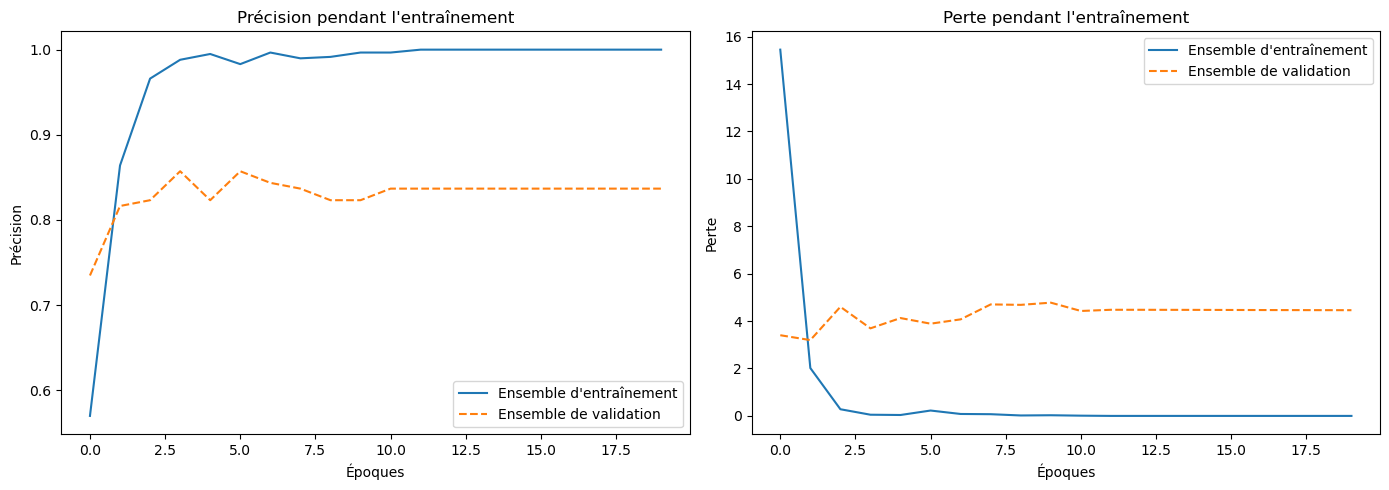

<Figure size 640x480 with 0 Axes>

In [339]:
PlotModel(history=history_img, metric='accuracy', metric_val='val_accuracy', loss='loss', val_loss='val_loss')
plt.savefig("path_to_save_image1.png")


In [323]:
print(np.array(X_test_cnn).shape)

(315, 25088)


In [324]:
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

10/10 [==============================] - 0s 6ms/step


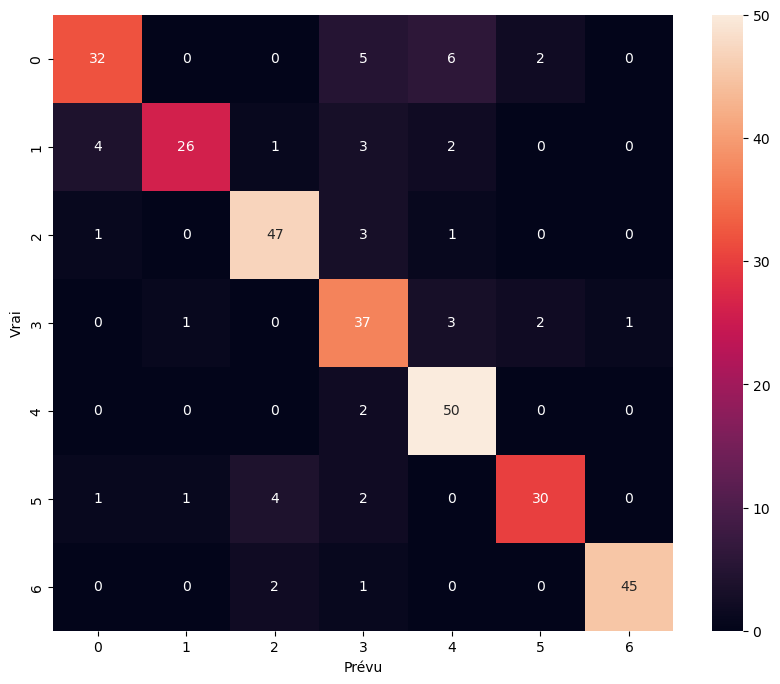

In [325]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Prévu')
plt.ylabel('Vrai')
plt.show()

In [326]:
print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.71      0.77        45
           1       0.93      0.72      0.81        36
           2       0.87      0.90      0.89        52
           3       0.70      0.84      0.76        44
           4       0.81      0.96      0.88        52
           5       0.88      0.79      0.83        38
           6       0.98      0.94      0.96        48

    accuracy                           0.85       315
   macro avg       0.86      0.84      0.84       315
weighted avg       0.86      0.85      0.85       315



In [329]:
# 1. Choisissez des images aléatoires
num_samples = 10  
random_image_paths = random.sample(image_paths, num_samples)
random_labels = [labels[image_paths.index(path)] for path in random_image_paths]

# 2.Extraire les fonctionnalités des images
random_features = [extract_features_from_image(img_path) for img_path in random_image_paths]

# 3. Prédiction des étiquettes à l'aide d'un modèle
predicted_probs = model.predict(np.array(random_features))
predicted_labels = np.argmax(predicted_probs, axis=1)

# Reconversion des étiquettes projetées en étiquettes de texte
predicted_label_names = label_encoder.inverse_transform(predicted_labels)

for true_label, predicted_label, path in zip(random_labels, predicted_label_names, random_image_paths):
    print(f"Image: {path}")
    print(f"True Label: {true_label}, Predicted Label: {predicted_label}")
    print("---------")

1/1 [==============================] - 0s 22ms/step
Image: ./data/source/Flipkart/images/e4922f01eda047582cd72e9d1063ab7a.jpg
True Label: Home Decor & Festive Needs, Predicted Label: Home Decor & Festive Needs
---------
Image: ./data/source/Flipkart/images/07912328f580cf080d721e6466287896.jpg
True Label: Home Decor & Festive Needs, Predicted Label: Home Decor & Festive Needs
---------
Image: ./data/source/Flipkart/images/74e5a3f6edb34d7e593a0d1854b0b886.jpg
True Label: Kitchen & Dining, Predicted Label: Kitchen & Dining
---------
Image: ./data/source/Flipkart/images/a76bf8400b3dbcdbe5a5678f4a8ea0f6.jpg
True Label: Computers, Predicted Label: Computers
---------
Image: ./data/source/Flipkart/images/f309bdd259c5b46a560bc1620e641947.jpg
True Label: Computers, Predicted Label: Computers
---------
Image: ./data/source/Flipkart/images/caabe6014b914fe2874a9a8d7284f79b.jpg
True Label: Home Decor & Festive Needs, Predicted Label: Home Decor & Festive Needs
---------
Image: ./data/source/Flipkar

Le modèle n'a commis aucune erreur de prédiction sur un ensemble aléatoire d'images

In [ ]:
"""
Le modèle a atteint une certaine limite de ses capacités sur les données.
Dans ce cas, nous devons étendre l'architecture du modèle, ajouter plus de données ou 
utiliser l'augmentation des données.
"""

# Classification d'images par augmentation de données (Data Augmentation)

In [384]:
loaded_model = load_model('path_to_my_model.h5')

In [385]:
print(loaded_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_11 (Dense)            (None, 7)                 903       
                                                                 
Total params: 6456583 (24.63 MB)
Trainable params: 6456583 (24.63 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


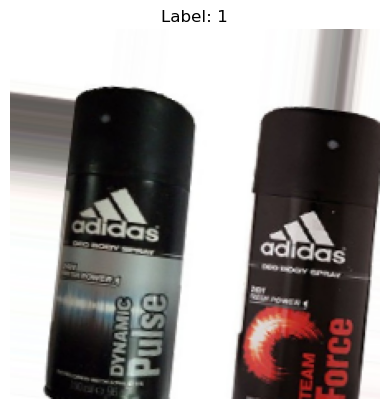

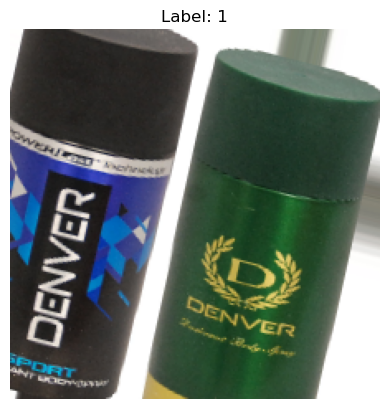

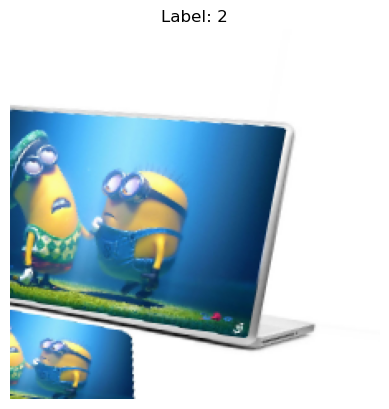

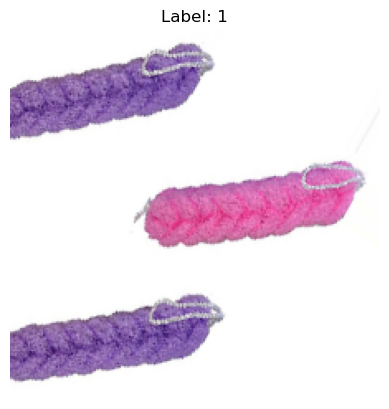

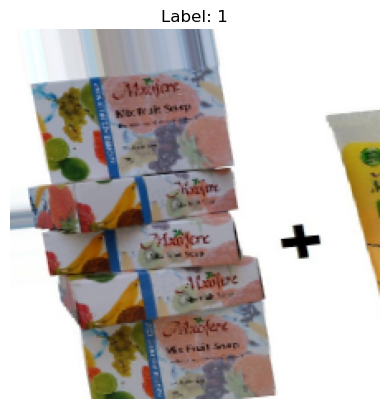

In [197]:
for i in range(5):
    plt.imshow(data_batch[i].astype('int'))
    plt.title(f"Label: {np.argmax(labels_batch[i])}")
    plt.axis("off")
    plt.savefig("1.png")
    plt.show()


In [ ]:
# répertoires
augmented_image_dir = '/Users/innakonar/Desktop/PythonScripts/data/augmented_images'
source_dir = '/Users/innakonar/Desktop/PythonScripts/data/source/Flipkart/images/'
dest_dir = '/Users/innakonar/Desktop/PythonScripts/data/images'

if not os.path.exists(augmented_image_dir):
    os.makedirs(augmented_image_dir)

In [ ]:
# Fonction d'ajout de champs blancs
def add_padding(img, expected_size=224):
    desired_size = expected_size
    delta_width = desired_size - img.width
    delta_height = desired_size - img.height
    padding = (delta_width//2, delta_height//2, delta_width-(delta_width//2), delta_height-(delta_height//2))
    return ImageOps.expand(img, padding, fill='white')

# Obtention d'un ensemble de données
X_new = np.array([img_to_array(load_img(os.path.join(dest_dir, cat, img), target_size=(224, 224))) 
                  for cat in os.listdir(dest_dir) 
                  if os.path.isdir(os.path.join(dest_dir, cat)) 
                  for img in os.listdir(os.path.join(dest_dir, cat))])
X_new = preprocess_input(X_new)

# Augmentation des données
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_X = []
augmented_y = []

y_new_encoded = LabelEncoder().fit_transform(y_new)
y_new_categorical = to_categorical(y_new_encoded)

# Multipliez l'ensemble de données
for x, y in zip(X_new, y_new_categorical):
    x = x.reshape((1, *x.shape))
    for _ in range(augment_factor):
        augmented_image = datagen.flow(x, batch_size=1).next()[0]
        augmented_X.append(augmented_image)
        augmented_y.append(y)

augmented_X = np.array(augmented_X)
augmented_y = np.array(augmented_y)

In [404]:
# Préparation d'un modèle1 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(len(np.unique(y_new)), activation='softmax')(x)
loaded_model = Model(inputs=base_model.input, outputs=predictions)

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = loaded_model.fit(augmented_X, augmented_y, epochs=10, batch_size=32, validation_split=0.2, verbose=1)
loss, accuracy = loaded_model.evaluate(augmented_X[int(0.8*len(augmented_X)):], augmented_y[int(0.8*len(augmented_y)):])

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

y_pred = loaded_model.predict(augmented_X[int(0.8*len(augmented_X)):])
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(augmented_y[int(0.8*len(augmented_y)):], axis=1)
report = classification_report(y_val_classes, y_pred_classes)
print(report)


Epoch 1/10
132/132 [==============================] - 586s 4s/step - loss: 6.7739 - accuracy: 0.2721 - val_loss: 2.2568 - val_accuracy: 0.0590
Epoch 2/10
132/132 [==============================] - 551s 4s/step - loss: 1.3490 - accuracy: 0.4862 - val_loss: 2.5028 - val_accuracy: 0.1200
Epoch 3/10
132/132 [==============================] - 587s 4s/step - loss: 1.0157 - accuracy: 0.6055 - val_loss: 2.6887 - val_accuracy: 0.1400
Epoch 4/10
132/132 [==============================] - 572s 4s/step - loss: 0.7216 - accuracy: 0.7064 - val_loss: 3.3983 - val_accuracy: 0.1352
Epoch 5/10
132/132 [==============================] - 554s 4s/step - loss: 0.5582 - accuracy: 0.7738 - val_loss: 3.6368 - val_accuracy: 0.1457
Epoch 6/10
132/132 [==============================] - 575s 4s/step - loss: 0.4500 - accuracy: 0.8210 - val_loss: 3.8953 - val_accuracy: 0.1343
Epoch 7/10
132/132 [==============================] - 572s 4s/step - loss: 0.3677 - accuracy: 0.8550 - val_loss: 4.6056 - val_accuracy: 0.1600

In [407]:
# Préparation d'un modèle2
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # Ajout de la régularisation L2
x = Dropout(0.5)(x)  # Ajout Dropout
predictions = Dense(len(np.unique(y_new)), activation='softmax', kernel_regularizer=l2(0.01))(x)  # Ajout de la régularisation L2
loaded_model = Model(inputs=base_model.input, outputs=predictions)

loaded_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



In [408]:
%%time
history = loaded_model.fit(augmented_X, augmented_y, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/10
132/132 [==============================] - 620s 5s/step - loss: 16.1130 - accuracy: 0.2324 - val_loss: 9.0972 - val_accuracy: 0.0467
Epoch 2/10
132/132 [==============================] - 696s 5s/step - loss: 7.7365 - accuracy: 0.3424 - val_loss: 7.5021 - val_accuracy: 0.0752
Epoch 3/10
132/132 [==============================] - 624s 5s/step - loss: 6.3518 - accuracy: 0.3719 - val_loss: 6.3230 - val_accuracy: 0.0752
Epoch 4/10
132/132 [==============================] - 889s 7s/step - loss: 5.4922 - accuracy: 0.3888 - val_loss: 6.0349 - val_accuracy: 0.0476
Epoch 5/10
132/132 [==============================] - 623s 5s/step - loss: 5.1351 - accuracy: 0.3883 - val_loss: 5.6583 - val_accuracy: 0.0600
Epoch 6/10
132/132 [==============================] - 869s 7s/step - loss: 4.8690 - accuracy: 0.4031 - val_loss: 6.0533 - val_accuracy: 0.1000
Epoch 7/10
132/132 [==============================] - 535s 4s/step - loss: 4.9313 - accuracy: 0.4029 - val_loss: 5.7648 - val_accuracy: 0.092

In [409]:
loss, accuracy = loaded_model.evaluate(augmented_X[int(0.8*len(augmented_X)):], augmented_y[int(0.8*len(augmented_y)):])

print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

33/33 [==============================] - 106s 3s/step - loss: 5.4135 - accuracy: 0.0676
Loss: 5.413518905639648
Accuracy: 0.06761904805898666


In [410]:
y_pred = loaded_model.predict(augmented_X[int(0.8*len(augmented_X)):])
y_pred_classes = np.argmax(y_pred, axis=1)
y_val_classes = np.argmax(augmented_y[int(0.8*len(augmented_y)):], axis=1)
report = classification_report(y_val_classes, y_pred_classes)
print(report)


33/33 [==============================] - 110s 3s/step
              precision    recall  f1-score   support

           0       0.11      0.02      0.04       210
           1       0.02      0.01      0.01        95
           2       0.19      0.03      0.05       180
           3       0.21      0.11      0.15       190
           4       0.27      0.05      0.09       315
           5       0.07      0.40      0.12        55
           6       0.00      0.20      0.00         5

    accuracy                           0.07      1050
   macro avg       0.12      0.12      0.07      1050
weighted avg       0.18      0.07      0.08      1050



l’augmentation des données ne conduit pas toujours à une amélioration des performances:nature des données ou un ensemble de données plus important peut nécessiter davantage d'époques de formation pour que le modèle s'adapte correctement aux nouvelles données.